[Introduction to Ensembling/Stacking in Python](https://www.kaggle.com/code/arthurtok/introduction-to-ensembling-stacking-in-python)

# Introduction

This notebook is a very basic and simple introductory primer to the method of ensembling(combining) base learning models, in particular the variant of ensembling known as Stacking. In a nutshell stacking uses as a first-level(base), the predictions of a few basic classifiers and then uses another model at the second-level to predict the output from the earlier first-level predictions.

The Titanic dataset is a prime candidate for introducing this concept as many newcomers to Kaggle start out here. Furthermore even though stacking has been responsible for many a team winning Kaggle competitions there seems to be a dearth of kernels on this topic so I hope this notebook can fill somewhat of that void.

I myself am quite a newcomer to the Kaggle scene as well and the first proper ensembling/stacking script that I managed to chance upon and study was one written in the AllState Severity Claims competition by the great Faron. The material in this notebook borrows heavily from Faron's script although ported to factor in ensembles of classifiers whilst his was ensembles of regressors.

Now onto the notebook at hand and I hope that it manages to do justice and convey the concept of ensembling in an intuitive and concise manner. My other standalone Kaggle script which implements exactly the same ensembling steps(albeit with different parameters) discussed below gives a Public LB score of 0.808 which is good enough to get to the top 9% and runs just under 4 minutes. Therefore I am pretty sure there is a lot of room to improve and add on to that script. Anyways please fell free to leave me any comments wtih regards to how I can improve.

In [1]:
# Load in our libraries
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.offline as py
import seaborn as sns
import sklearn
import xgboost as xgb

py.init_notebook_mode(connected=True)
import warnings

import plotly.graph_objs as go
import plotly.tools as tls

warnings.filterwarnings("ignore")

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.model_selection import KFold
from sklearn.svm import SVC

# Feature Exploration, Engieering and Cleaning

Now we will proceed much like how most kernel in general are structed, and that is to first explore the data on hand, identify possible feature engineering opportunities as well as numerically encode any categorical features.

In [2]:
# Load in the train and test datasets
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

# Store our passenger ID for easy access
PassengerId = test["PassengerId"]

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Well it is no surprise that our task is to somehow extract the information out of the categorical values.

**Feature Engineering**

In [3]:
full_data = [train, test]

In [4]:
# Gives the length of the name
train["Name_length"] = train["Name"].apply(len)
test["Name_length"] = test["Name"].apply(len)

In [5]:
# Feature that tells whether a passenger had a cabin on the Titanic
train["Has_Cabin"] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test["Has_Cabin"] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [6]:
# Craete new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset["FamilySize"] = dataset["SibSp"] = dataset["Parch"] + 1

In [7]:
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset["IsAlone"] = 0
    dataset.loc[dataset["FamilySize"] == 1, "IsAlone"] = 1

In [8]:
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset["Embarked"] = dataset["Embarked"].fillna("S")

In [9]:
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset["Fare"] = dataset["Fare"].fillna(train["Fare"].median())
train["CategoricalFare"] = pd.qcut(train["Fare"], 4)

In [10]:
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset["Age"].mean()
    age_std = dataset["Age"].std()
    age_null_count = dataset["Age"].isnull().sum()
    age_null_random_list = np.random.randint(
        age_avg - age_std, age_avg + age_std, age_null_count
    )
    dataset["Age"][np.isnan(dataset["Age"])] = age_null_random_list
    dataset["Age"] = dataset["Age"].astype(int)
train["CategoricalAge"] = pd.cut(train["Age"], 5)

In [11]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(" ([A-Za-z]+)\.", name)
    # If the title exists, extract and return it
    if title_search:
        return title_search.group(1)
    return ""


# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset["Title"] = dataset["Name"].apply(get_title)

# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset["Title"] = dataset["Title"].replace(
        [
            "Lady",
            "Countess",
            "Capt",
            "Col",
            "Don",
            "Dr",
            "Major",
            "Rev",
            "Sir",
            "Jonkheer",
            "Dona",
        ],
        "Rare",
    )
    dataset["Title"] = dataset["Title"].replace(["Mlle", "Ms"], "Miss")
    dataset["Title"] = dataset["Title"].replace("Mme", "Mrs")

In [12]:
for dataset in full_data:
    # Mapping Sex
    dataset["Sex"] = dataset["Sex"].map({"female": 0, "male": 1}).astype(int)

    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset["Title"] = dataset["Title"].map(title_mapping)
    dataset["Title"] = dataset["Title"].fillna(0)

    # Mapping Embarked
    dataset["Embarked"] = dataset["Embarked"].map({"S": 0, "C": 1, "Q": 2}).astype(int)

    # Mapping Fare
    dataset.loc[dataset["Fare"] <= 7.91, "Fare"] = 0
    dataset.loc[(dataset["Fare"] > 7.91) & (dataset["Fare"] <= 14.454), "Fare"] = 1
    dataset.loc[(dataset["Fare"] > 14.454) & (dataset["Fare"] <= 31), "Fare"] = 2
    dataset.loc[dataset["Fare"] > 31, "Fare"] = 3
    dataset["Fare"] = dataset["Fare"].astype(int)

    # Mapping Age
    dataset.loc[dataset["Age"] <= 16, "Age"] = 0
    dataset.loc[(dataset["Age"] > 16) & (dataset["Age"] <= 32), "Age"] = 1
    dataset.loc[(dataset["Age"] > 32) & (dataset["Age"] <= 48), "Age"] = 2
    dataset.loc[(dataset["Age"] > 48) & (dataset["Age"] <= 64), "Age"] = 3
    dataset.loc[dataset["Age"] > 64, "Age"] = 4

In [13]:
# Feature selection
drop_elements = ["PassengerId", "Name", "Ticket", "Cabin", "SibSp"]
train = train.drop(drop_elements, axis=1)
train = train.drop(["CategoricalAge", "CategoricalFare"], axis=1)
test = test.drop(drop_elements, axis=1)

All right so now having cleaned the features and extracted relevant informations and dropped the categorical columns our features should now all be numeric, a format suitable to feed into our Machine Learning models. However before we proceed let us generate some simple correlation and distribution plots of our transformed dataset to observe.

## Visualisations

In [14]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,1,1,1
1,1,1,0,2,0,3,1,51,1,1,1,3
2,1,3,0,1,0,1,0,22,0,1,1,2


**Pearson Correlation Heatmap**

let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilise the Seaborn plotting package which allows us to plot heatmaps very conveniently as follows

<Axes: title={'center': 'Pearson Correlation of Features'}>

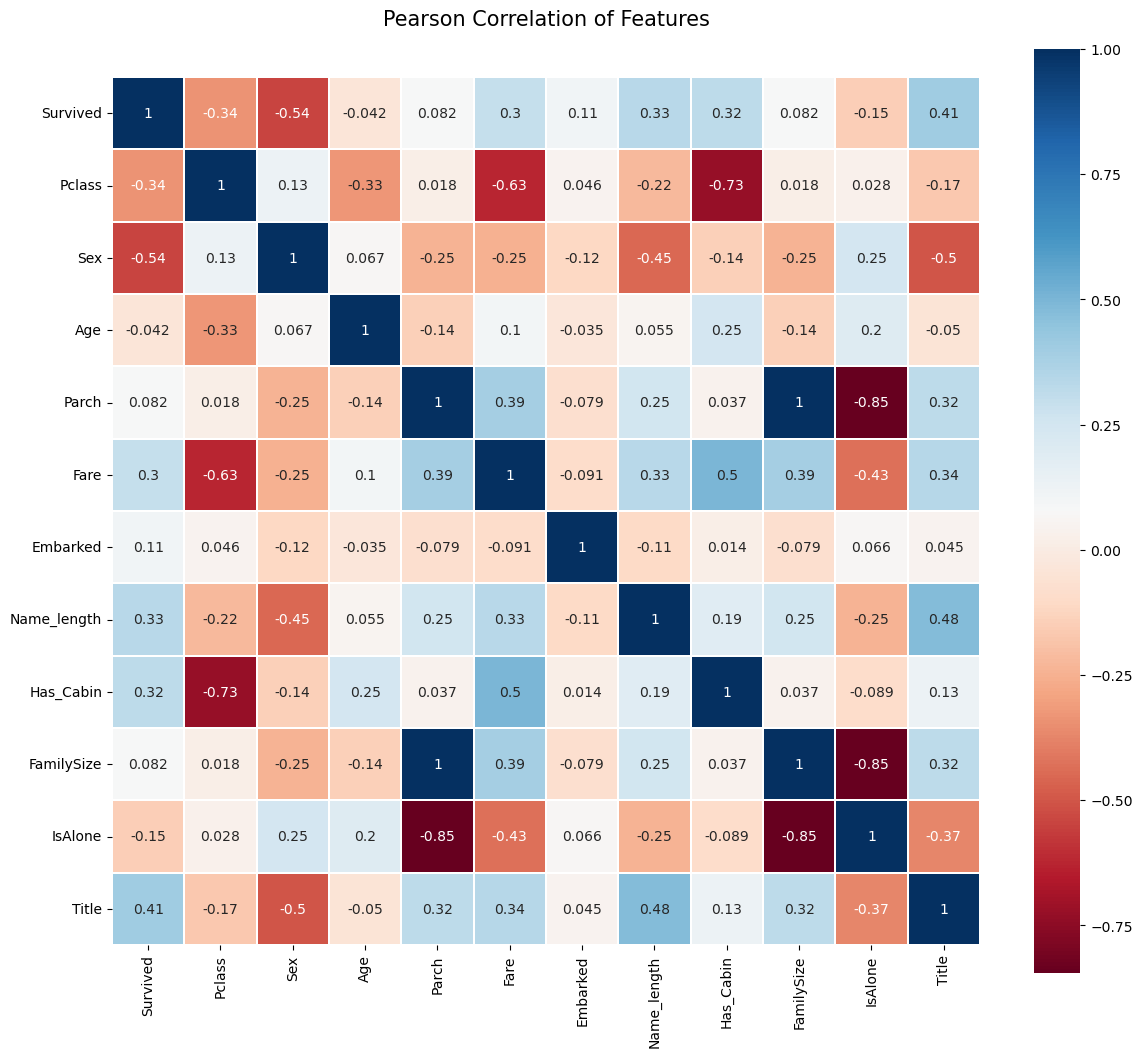

In [15]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title("Pearson Correlation of Features", y=1.05, size=15)
sns.heatmap(
    train.astype(float).corr(),
    linewidths=0.1,  # 각 셀 간 경계선 두께
    vmax=1.0,  # 히트맵 색상 범위(1.0이 최대)
    square=True,  # 히트맵 셀을 정사각형 모양으로 유지
    cmap=colormap,
    linecolor="white",  # 셀 간경계선 색
    annot=True,  # 각 셀에 상관계수 값을 텍스트로 표시. True로 설정하면, 셀 안에 상관계수 값 출력
)

**Takeaway from the Plots**

One thing that the Pearson Correlation plot can tell us is that there are not too many features strongly correlated with one another. This is good from a point of view of feeding these features into your learning model because this means that there isn't much redundant or superfluous data in our training set and we are happy that each feature caries with it some unique information. Here are two most correlated features are that of Family size and parch(Parents and Children). I'll still leave both features in for the purposes of this exercise.

**Pairplots**

Finally let us generate some pairplots to observe the distribution of data from one feature to the other. Once again we use Seaborn to help us.

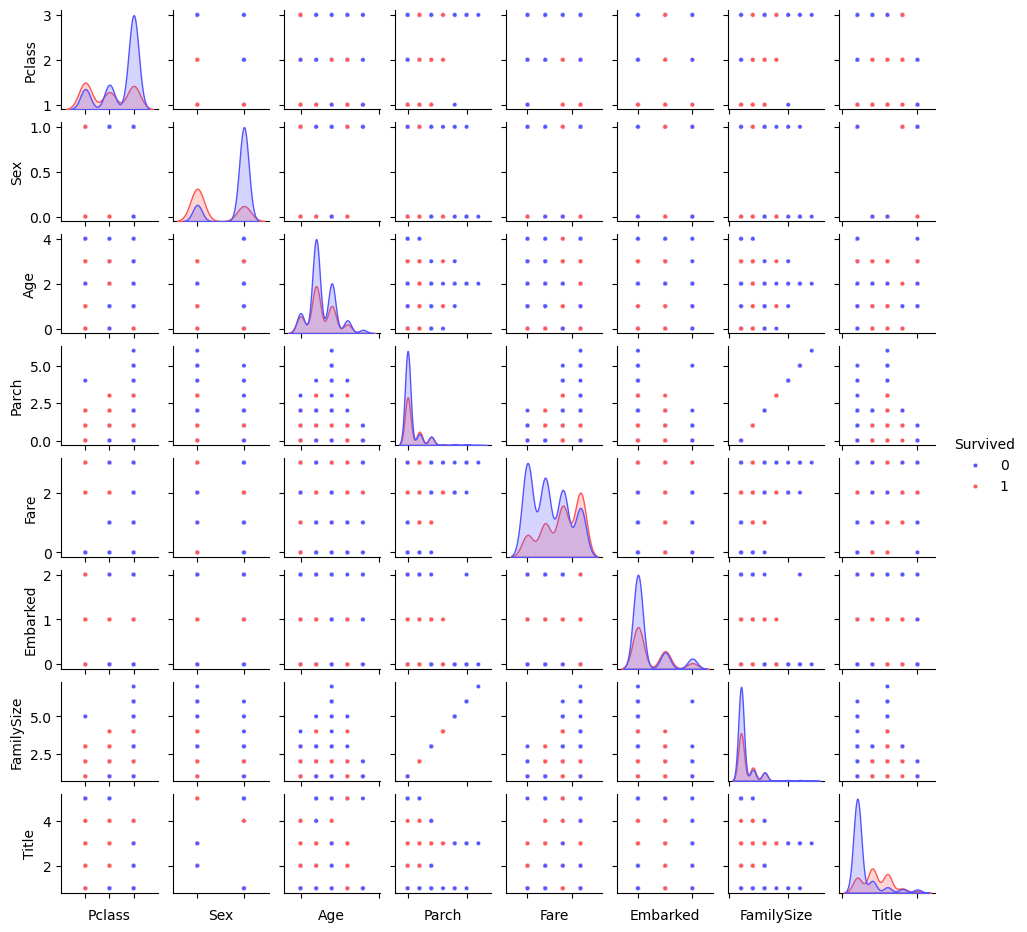

In [16]:
g = sns.pairplot(
    train[
        [
            "Survived",
            "Pclass",
            "Sex",
            "Age",
            "Parch",
            "Fare",
            "Embarked",
            "FamilySize",
            "Title",
        ]
    ],
    hue="Survived",
    palette="seismic",
    height=1.2,
    diag_kind="kde",
    diag_kws={"shade": True},
    plot_kws={"s": 10},
)
g.set(xticklabels=[])

# Ensembling & Stacking models

Finally after that brief whirlwind detour with regards to feature engineering and formatting, we finally arrive at the meat and gist of the this notebook.

Creating a Stacking ensemble!

### Helpers via Python Classes

Here we invoke the use of Python's classes to help make it more convenient for us. For any newcomers to programming, one normally hears Classes being used in conjunction with Object-Oriented Programming(OOP). In short, a class helps to extend some code/program for creating objects(variables for old-school peeps) as well as to implement functions and methods specific to that class.

In the section of code below, we essentially write a class SklearnHelper that allows one to extend the inbuilt methods (such as train, predict and fit) common to all the Sklearn classifiers. Therefore this cuts out redundancy as won't need to write the same methods five times if we wanted to invoke five different classifiers.

In [17]:
# Some useful params which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
N_SPLITS = 5
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

In [18]:
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params["random_state"] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def fit(self, x, y):
        return self.clf.fit(x, y)

    def feature_importances(self, x, y):
        return self.clf.fit(x, y).feature_importances_

### Out-of-Fold Predictions

Now as alluded to above in the introductory section, stacking uses predictions of base classifiers as input for training to a second-level model. However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training. This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

stacking에서는 위와 같은 문제를 해결하기 위해 OOF 예측을 사용합니다.
1. 각 폴드에서 K-1개의 폴드를 사용하여 모델을 훈련시킵니다.
2. 훈련되지 않은 1개의 폴드에 대해 모델이 예측을 수행합니다. 이 예측값이 Out-of-Fold 예측입니다.
3. 이 과정을 모든 폴드에 대해 반복하여 각 데이터 포인트는 자신이 속한 폴드에서 훈련되지 않은 상태로 예측된 결과값을 가지게 됩니다. 이렇게 생성된 OOF 예측값을 2단계 모델의 훈련에 사용합니다.

In [19]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((N_SPLITS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Generating our Base First-Level Models

So now let us prepare five learning models as our first level classification. These models can all be conveniently invoked via the Sklearn library and are listed as follows.:
1. Random Forest classifier
2. Extra Trees classifier
3. AdaBoost classifier
4. Gradient Boosting classifier
5. Support Vector Machine

**Parameters**

Just a quick summary of the params that we will be listing here for completeness,

**n_jobs**: Number of cores used for training process. If set to -1, all cores are used.

**n_estimators**: Number of classification trees in your learning model(set to 10 per default)

**max_depth**: Maximum depth of tree, or how much a node should be expanded. Beware if set too high a number would run the risk of overfitting as one would be growing the tree too deep

**verbose**: Controls whether you want to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.

Please check out the full description via the official Sklearn website. There you will find that there are a whole host of other useful params that you can play around with.

In [20]:
# Put in our params for said classifiers
# Random Forest params
rf_params = {
    "n_jobs": -1,
    "n_estimators": 500,
    # True로 설정 시 이전 fit 메서드 호출 시 학습 결과를 재사용하고, 앙상블에 더 많은 추정기 추가
    "warm_start": True,
    # "max_features": 0.2,
    "max_depth": 6,
    "min_samples_leaf": 2,
    "max_features": "sqrt",  # best split을 찾기 위해 고려할 feature의 수
    "verbose": 0,
}

# Extra Trees params
et_params = {
    "n_jobs": -1,
    "n_estimators": 500,
    # "max_features": 0.5,
    "max_depth": 8,
    "min_samples_leaf": 2,
    "verbose": 0,
}

# AdaBoost params
ada_params = {
    "n_estimators": 500,
    "learning_rate": 0.75,
}

# Gradient Boosting params
gb_params = {
    "n_estimators": 500,
    # "max_features": 0.2,
    "max_depth": 5,
    "min_samples_leaf": 2,
    "verbose": 0,
}

# Support Vector Classifier params
svc_params = {"kernel": "linear", "C": 0.025}

Furthermore, since having mentioned about Objects and classes within the OOP framework, let us now create 5 objects that represent our 5 learning models via our Helper Sklearn Class we defined earlier.

In [21]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

**Createing Numpy arrays out of our train and test sets**

Great. Having prepared our first layer base models as such, we can now ready the training and test data for input into our classifiers by generating Numpy arrays out of their original dataframes as follows:

In [22]:
# Create Numpy arrays of train, test and target(Survived) dataframes to feed into our models
y_train = train["Survived"].ravel()
train = train.drop(["Survived"], axis=1)
x_train = train.values
x_test = test.values

**Ouput of the First level Predictions**
We now feed the training and test data into our 5 base classifiers and use the Out-of-Fold prediction function we defined earlier to generate our first level predictions. Allow a handful of minutes for the chunk of code below to run.

In [23]:
# Create our OOF train and test predictions. These base results will be used as new features
# Extra Trees
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
# Random Forest
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)
# AdaBoost
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
# Gradient Boost
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)
# Support Vector Classifier
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)

print("Training is complete")

Training is complete


**Feature importances generated from the different classifiers**

Now having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models and that is to output the importances of the various features in the training and test sets with one very simple line of code.

As per the Sklearn documentation, most of the classifiers are built in with an attribute which returns feature importances by simply typing in **.feature\_importances\_**. Therefore we will invoke this very useful attribute via our function and plot the feature importances as such

In [24]:
rf_features = rf.feature_importances(x_train, y_train)
et_features = et.feature_importances(x_train, y_train)
ada_features = ada.feature_importances(x_train, y_train)
gb_features = gb.feature_importances(x_train, y_train)

Create a dataframe from the lists containing the feature importance data for easy plotting via the Plotly package.

In [25]:
cols = train.columns.values

feature_dataframe = pd.DataFrame(
    {
        "features": cols,
        "Random Forest feature importances": rf_features,
        "Extra Trees feature importances": et_features,
        "AdaBoost feature importances": ada_features,
        "Gradient Boost feature importances": gb_features,
    }
)

**Interactive feature importances via Plotly scatterplots**

I'll use the interactive Plotly package at this juncture to visualise the feature importances values of the different classifiers via a plotly scatter plot by calling "Scatter" as follows:

In [26]:
# Random Forest
trace = go.Scatter(
    y=feature_dataframe["Random Forest feature importances"].values,
    x=feature_dataframe["features"].values,
    mode="markers",  # 산점도를 점으로 표시
    # 점의 속성
    marker=dict(
        sizemode="diameter",  # 점의 크기를 지름으로 조정
        sizeref=1,  # 점의 크기를 참조할 값
        size=25,  # 점의 기본 크기를 25
        # 점의 색을 중요도 값에 따라
        color=feature_dataframe["Random Forest feature importances"].values,
        colorscale="Portland",
        showscale=True,  # 색상 막대 표시
    ),
    text=feature_dataframe["features"].values,  # 각 점에 마우스 올리면 표시될 텍스트
)
data = [trace]

# 그래프의 레이아웃 정의
layout = go.Layout(
    autosize=True,  # 그래프 크기 자동 조정
    title="Random Forest Feature Importance",
    hovermode="closest",  # 마우스를 점에 올릴 때 가장 가까운 점에 대한 정보 표시
    # 눈금 길이 5, y축 그리드 라인 너비 2
    yaxis=dict(title="Feature Importance", ticklen=5, gridwidth=2),
    showlegend=False,
)

# 데이터를 시각화하는 객체, data와 layout을 기반으로 그래프 생성
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="scatter2010")

In [27]:
# Extra Trees
trace = go.Scatter(
    y=feature_dataframe["Extra Trees feature importances"].values,
    x=feature_dataframe["features"].values,
    mode="markers",  # 산점도를 점으로 표시
    # 점의 속성
    marker=dict(
        sizemode="diameter",  # 점의 크기를 지름으로 조정
        sizeref=1,  # 점의 크기를 참조할 값
        size=25,  # 점의 기본 크기를 25
        # 점의 색을 중요도 값에 따라
        color=feature_dataframe["Extra Trees feature importances"].values,
        colorscale="Portland",
        showscale=True,  # 색상 막대 표시
    ),
    text=feature_dataframe["features"].values,  # 각 점에 마우스 올리면 표시될 텍스트
)
data = [trace]

# 그래프의 레이아웃 정의
layout = go.Layout(
    autosize=True,  # 그래프 크기 자동 조정
    title="Extra Trees Feature Importance",
    hovermode="closest",  # 마우스를 점에 올릴 때 가장 가까운 점에 대한 정보 표시
    # 눈금 길이 5, y축 그리드 라인 너비 2
    yaxis=dict(title="Feature Importance", ticklen=5, gridwidth=2),
    showlegend=False,
)

# 데이터를 시각화하는 객체, data와 layout을 기반으로 그래프 생성
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="scatter2010")

In [28]:
# Extra Trees
trace = go.Scatter(
    y=feature_dataframe["AdaBoost feature importances"].values,
    x=feature_dataframe["features"].values,
    mode="markers",  # 산점도를 점으로 표시
    # 점의 속성
    marker=dict(
        sizemode="diameter",  # 점의 크기를 지름으로 조정
        sizeref=1,  # 점의 크기를 참조할 값
        size=25,  # 점의 기본 크기를 25
        # 점의 색을 중요도 값에 따라
        color=feature_dataframe["AdaBoost feature importances"].values,
        colorscale="Portland",
        showscale=True,  # 색상 막대 표시
    ),
    text=feature_dataframe["features"].values,  # 각 점에 마우스 올리면 표시될 텍스트
)
data = [trace]

# 그래프의 레이아웃 정의
layout = go.Layout(
    autosize=True,  # 그래프 크기 자동 조정
    title="AdaBoost Feature Importance",
    hovermode="closest",  # 마우스를 점에 올릴 때 가장 가까운 점에 대한 정보 표시
    # 눈금 길이 5, y축 그리드 라인 너비 2
    yaxis=dict(title="Feature Importance", ticklen=5, gridwidth=2),
    showlegend=False,
)

# 데이터를 시각화하는 객체, data와 layout을 기반으로 그래프 생성
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="scatter2010")

In [29]:
# Extra Trees
trace = go.Scatter(
    y=feature_dataframe["Gradient Boost feature importances"].values,
    x=feature_dataframe["features"].values,
    mode="markers",  # 산점도를 점으로 표시
    # 점의 속성
    marker=dict(
        sizemode="diameter",  # 점의 크기를 지름으로 조정
        sizeref=1,  # 점의 크기를 참조할 값
        size=25,  # 점의 기본 크기를 25
        # 점의 색을 중요도 값에 따라
        color=feature_dataframe["Gradient Boost feature importances"].values,
        colorscale="Portland",
        showscale=True,  # 색상 막대 표시
    ),
    text=feature_dataframe["features"].values,  # 각 점에 마우스 올리면 표시될 텍스트
)
data = [trace]

# 그래프의 레이아웃 정의
layout = go.Layout(
    autosize=True,  # 그래프 크기 자동 조정
    title="Gradient Boost Feature Importance",
    hovermode="closest",  # 마우스를 점에 올릴 때 가장 가까운 점에 대한 정보 표시
    # 눈금 길이 5, y축 그리드 라인 너비 2
    yaxis=dict(title="Feature Importance", ticklen=5, gridwidth=2),
    showlegend=False,
)

# 데이터를 시각화하는 객체, data와 layout을 기반으로 그래프 생성
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="scatter2010")

Now let us calculate the mean of all the feature importances and store it as a new column in the feature importance dataframe.

In [30]:
# Create the new column containing the average of values
feature_dataframe["mean"] = feature_dataframe.mean(
    numeric_only=True, axis=1
)  # axis=1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.118421,0.129508,0.038,0.113263,0.099798
1,Sex,0.220797,0.385255,0.010,0.006972,0.155756
2,Age,0.031781,0.027774,0.014,0.047271,0.030207


**Plotly Barplot of Average Feature Importances**

Having obtained the mean feature importance across all our classifiers, we can plot them into a Plotly bar plot as follows:

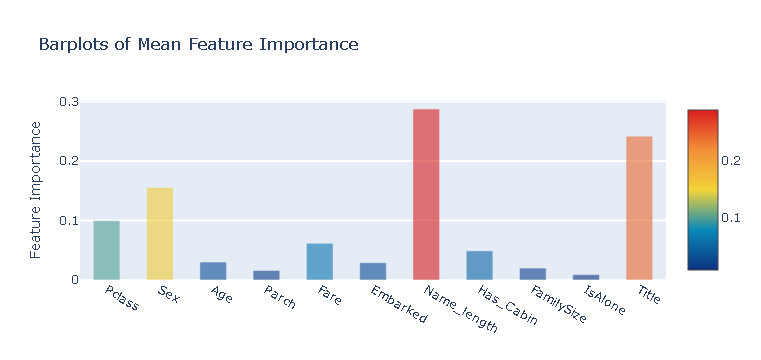

In [31]:
x = feature_dataframe["features"].values
y = feature_dataframe["mean"].values
data = [
    go.Bar(
        x=x,
        y=y,
        width=0.5,
        marker=dict(
            color=feature_dataframe["mean"].values,
            colorscale="Portland",
            showscale=True,
            reversescale=False,
        ),
        opacity=0.6,
    )
]

layout = go.Layout(
    autosize=True,
    title="Barplots of Mean Feature Importance",
    hovermode="closest",
    yaxis=dict(title="Feature Importance", ticklen=5, gridwidth=2),
    showlegend=False,
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="bar-direct-labels")